In [ ]:
!pip install Levenshtein -q
!pip install -q --upgrade git+https://github.com/huggingface/transformers.git
!pip install -q datasets lightning
!pip install -q peft accelerate bitsandbytes
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# log in to hugging face
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()
import time

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if the directory exists and copy if it does not exist
import os
import shutil

# List of files to copy
files = ["train.json", "train.zip", "valid.json", "valid.zip"]

# Source directory
src_dir = "drive/MyDrive/matsuo-ken-2024-DL/VQA/VQA"

# Destination directory
dest_dir = "./data"

# Ensure the destination directory exists
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Copy files one by one
for file in files:
    src_file = os.path.join(src_dir, file)
    dest_file = os.path.join(dest_dir, file)

    if not os.path.exists(dest_file):
        shutil.copy(src_file, dest_file)
        print(f"{file} copied.")
    else:
        print(f"{file} already exists, not copying.")

train.json copied.
train.zip copied.
valid.json copied.
valid.zip copied.


In [ ]:
import os
import zipfile

def unzip_file(zip_path, extract_to, filename):
    if os.path.isfile(zip_path) and not os.path.isdir(extract_to + filename):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted {zip_path} to {extract_to}")
    else:
        if not os.path.isfile(zip_path):
            print(f"{zip_path} not found.")
        else:
            print(f"{extract_to} already exists.")

# Specify the paths for your zip files and target directories
train_zip_path = './data/train.zip'
train_extract_to = './data/'
valid_zip_path = './data/valid.zip'
valid_extract_to = './data/'

# Unzip the files
unzip_file(train_zip_path, train_extract_to, 'train')
unzip_file(valid_zip_path, valid_extract_to, 'valid')

Extracted ./data/train.zip to ./data/
Extracted ./data/valid.zip to ./data/


In [ ]:
INPUT_PATH = './data'
TRAIN_PATH = INPUT_PATH + '/train'
VALIDATION_PATH = INPUT_PATH + '/valid'
ANNOTATIONS_TRAIN_PATH = INPUT_PATH + '/train.json'
ANNOTATIONS_VAL_PATH = INPUT_PATH + '/valid.json'
OUTPUT_PATH = '/content/drive/MyDrive/matsuo-ken-2024-DL/VQA/OPENAI_CLIP/'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_REPO_ID = "google/paligemma-3b-pt-224"
MAX_LENGTH = 512

In [ ]:
def load_df(df_path):
    df = pd.read_json(df_path)
    df = df[['image', 'question', 'answers']]
    return df

train_df = load_df(ANNOTATIONS_TRAIN_PATH)
# train_df, val_df = train_test_split(train_df, test_size=0.005, random_state=42)
val_df = train_df[:100]

In [ ]:
class VQATrainDataset(Dataset):
    def __init__(self, df, image_dir, max_length=512):
        super().__init__()
        self.max_length = max_length
        self.image_dir = image_dir
        self.df = df
        self.copied_df = None

        self.questions = []
        self.image_paths = []
        self.answers = []

        self.build_answer_vocab()
        self.load_data()

    def load_data(self):
        for index, row in tqdm(self.df.iterrows(), total=len(self.df), leave=True, position=0):
            image_path = self.image_dir + '/' + row['image']
            self.image_paths.append(image_path)
            question = row['question']
            answer = self.copied_df.at[index, 'answer']

            self.questions.append(question)
            self.answers.append(answer)

    def build_answer_vocab(self):
        self.copied_df = self.df.copy()
        self.copied_df.drop(columns=['answers'], inplace=True)
        self.copied_df['answer'] = None

        for index, row in self.df.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])

            top_answers = intermediate_counter.most_common(1)
            if len(top_answers) == 1:
                self.copied_df.at[index, 'answer'] = top_answers[0][0]
            else:
                current_min = np.inf
                current_ans = None
                for answer in top_answers:
                    total_distance = 0
                    for answer2 in top_answers:
                        if answer != answer2:
                            lev_distance = lev.distance(answer[0], answer2[0])
                            total_distance += lev_distance
                    if total_distance < current_min:
                        current_min = total_distance
                        current_ans = answer[0]
                self.copied_df.at[index, 'answer'] = current_ans
        return

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except OSError:
            cvimg = cv2.imread(image_path)
            image = Image.fromarray(cvimg)
        question = self.questions[idx]
        answers = self.answers[idx]

        return image, question, answers


class VQAValDataset(Dataset):
    def __init__(self, df, image_dir, max_length=512):
        super().__init__()
        self.max_length = max_length
        self.image_dir = image_dir
        self.df = df
        self.questions = []
        self.image_paths = []
        self.answers = []

        self.load_data()

    def load_data(self):
        for index, row in tqdm(self.df.iterrows(), total=len(self.df), leave=True, position=0):
            image_path = self.image_dir + '/' + row['image']
            question = row['question']
            answers = [answer_map['answer'] for answer_map in row['answers']]
            self.image_paths.append(image_path)
            self.questions.append(question)
            self.answers.append(answers)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except OSError:
            cvimg = cv2.imread(image_path)
            image = Image.fromarray(cvimg)
        question = self.questions[idx]
        answers = self.answers[idx]

        return image, question, answers

In [ ]:
train_dataset = VQATrainDataset(train_df, TRAIN_PATH)

100%|██████████| 19873/19873 [00:01<00:00, 16573.22it/s]


In [ ]:
val_dataset = VQAValDataset(val_df, TRAIN_PATH)

100%|██████████| 100/100 [00:00<00:00, 16539.71it/s]


In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(MODEL_REPO_ID)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [ ]:
PROMPT = "Answer: "

def train_collate_fn(examples_):
    examples = examples_.copy()
    images = [example[0] for example in examples]
    questions = [PROMPT + example[1] for example in examples]
    answers = [example[2] for example in examples]

    inputs = processor(text=questions, images=images, suffix=answers, return_tensors="pt", padding=True,
                        truncation="only_second", max_length=MAX_LENGTH,
                        tokenize_newline_separately=False)

    input_ids = inputs["input_ids"]
    token_type_ids = inputs["token_type_ids"]
    attention_mask = inputs["attention_mask"]
    pixel_values = inputs["pixel_values"]
    labels = inputs["labels"]

    return input_ids, token_type_ids, attention_mask, pixel_values, labels

def eval_collate_fn(examples):
    images = [example[0] for example in examples]
    questions = [PROMPT + example[1] for example in examples]
    answers = [example[2] for example in examples]

    inputs = processor(text=questions, images=images, return_tensors="pt", padding=True, tokenize_newline_separately=False)

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    pixel_values = inputs["pixel_values"]

    return input_ids, attention_mask, pixel_values, answers

In [ ]:
train_dataloader = DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=8, shuffle=True)
input_ids, token_type_ids, attention_mask, pixel_values, labels = next(iter(train_dataloader))

val_dataloader = DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=2, shuffle=False)
input_ids, attention_mask, pixel_values, answers = next(iter(val_dataloader))

In [ ]:
import lightning as L
import re
from nltk import edit_distance

def VQA_criterion(batch_pred: torch.Tensor, batch_answers: torch.Tensor):
    total_acc = 0.

    for pred, answers in zip(batch_pred, batch_answers):
        total_acc += VQA_eval(pred, answers)

    return total_acc / len(batch_pred)

def VQA_eval(pred, answers):
    acc = 0.
    pred = process_pred(pred)
    for i in range(len(answers)):
        num_match = 0
        for j in range(len(answers)):
            if i == j:
                continue
            if pred == answers[j]:
                num_match += 1
        acc += min(num_match / 3, 1)
    return acc / 10

def process_pred(pred):
    pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
    if "unanswer" in pred:
        pred = "unanswerable"
    return pred

class PaliGemmaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):
        input_ids, token_type_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch
        with torch.no_grad():
            # autoregressively generate token IDs
            generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                        pixel_values=pixel_values, max_new_tokens=MAX_LENGTH)
            # turn them back into text, chopping of the prompt
            # important: we don't skip special tokens here, because we want to see them in the output
            predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

            vizwiz_acc = VQA_criterion(predictions, answers)
            for pred, answer in zip(predictions, answers):
                pred = process_pred(pred)

                if self.config.get("verbose", False):
                    print(f"Prediction: {pred}")
                    print(f"    Answer: {answer}")


            self.log("vizwiz_accuracy", vizwiz_acc)
            print(f"Vizwiz accuracy: {vizwiz_acc}")

        return vizwiz_acc

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [ ]:
from transformers import PaliGemmaForConditionalGeneration
from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

# use this for Q-LoRa
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_REPO_ID, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


In [ ]:
config = {"max_epochs": 7,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 3e-4,
          "batch_size": 4,
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = PaliGemmaModelPLModule(config, processor, model)

In [ ]:
FINETUNED_MODEL_ID = "howarudo/paligemma-vqa-ft-colab-3e4"

In [ ]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from huggingface_hub import HfApi

api = HfApi()


class PushToHubCallback(Callback):
    def __init__(self):
        self.model_id = FINETUNED_MODEL_ID

    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(
            self.model_id + f"-epoch_{trainer.current_epoch}",
            commit_message=f"Training in progress, epoch {trainer.current_epoch}",
        )
        pl_module.processor.push_to_hub(
            self.model_id + f"-epoch_{trainer.current_epoch}",
            commit_message=f"Training in progress, epoch {trainer.current_epoch}",
        )

    def on_train_end(self, trainer, pl_module):
        print("Pushing model to the hub after training")
        # Save and push model
        pl_module.model.push_to_hub(
            self.model_id + f"-epoch_{trainer.current_epoch}",
            commit_message="Training done"
        )
        # Save and push processor if it exists
        pl_module.processor.push_to_hub(
            self.model_id + f"-epoch_{trainer.current_epoch}",
            commit_message="Training done"
        )



early_stop_callback = EarlyStopping(monitor="vizwiz_accuracy", patience=10, verbose=False, mode="min")

In [ ]:
from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
torch.set_float32_matmul_precision('high')

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 1.7 B  | train
-------------------------------------------------------
11.3 M    Trainable params
1.7 B     Non-trainable params
1.7 B     Total params
6,948.584 Total estimated model params size (MB)
INFO

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: beef chuck steak
    Answer: ['beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'flat iron beef chuck steak', 'beef chuck steak', 'steak', 'flat iron beef chuck steak', 'beef chuck steak', 'beef chuck steak']
Prediction: unanswerable
    Answer: ['unanswerable', 'unanswerable', 'unanswerable', 'candle', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable']
Prediction: grey
    Answer: ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
Prediction: unanswerable
    Answer: ['lotion', 'lotion', 'unanswerable', 'yes', 'lotion', 'body wash', 'no', 'lotion', 'lotion', 'lotion']
Vizwiz accuracy: 0.825


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Prediction: no
    Answer: ['no', 'unanswerable', 'no', 'unanswerable', 'no', 'paper', 'no', 'no', 'yes', 'no']
Prediction: sun chips
    Answer: ['sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'sun chips', 'sun chips']
Prediction: shampoo
    Answer: ['shampoo', 'head shoulders', 'head shoulders refreshing shampoo', 'shampoo', 'shampoo', 'head shoulders shampoo', 'head shoulders shampoo', 'shampoo', 'shampoo', 'shampoo']
Prediction: unanswerable
    Answer: ['camera', 'brail machine', 'unanswerable', 'braille display', 'unanswerable', 'unanswerable', 'unanswerable', 'vision impaired keyboard', 'humanware', 'braille display writer']
Vizwiz accuracy: 1.0
Prediction: paper
    Answer: ['computer paper', 'paper', 'invoice', 'unanswerable', 'not clear', 'old feeder type printer paper', 'sticky labels', 'paper', 'shipping label sheet', 'dot matrix printer paper']
Prediction: brown
    Answer: ['brown', 'brown', 'brown', 'brown rice', 'brown',

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: beef chuck steak
    Answer: ['beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'flat iron beef chuck steak', 'beef chuck steak', 'steak', 'flat iron beef chuck steak', 'beef chuck steak', 'beef chuck steak']
Prediction: unanswerable
    Answer: ['unanswerable', 'unanswerable', 'unanswerable', 'candle', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable']
Prediction: grey
    Answer: ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
Prediction: unanswerable
    Answer: ['lotion', 'lotion', 'unanswerable', 'yes', 'lotion', 'body wash', 'no', 'lotion', 'lotion', 'lotion']
Vizwiz accuracy: 0.825
Prediction: no
    Answer: ['no', 'unanswerable', 'no', 'unanswerable', 'no', 'paper', 'no', 'no', 'yes', 'no']
Prediction: sun chips
    Answer: ['sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'sun chips', 'sun chips']
Prediction: sha

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: beef chuck steak
    Answer: ['beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'flat iron beef chuck steak', 'beef chuck steak', 'steak', 'flat iron beef chuck steak', 'beef chuck steak', 'beef chuck steak']
Prediction: unanswerable
    Answer: ['unanswerable', 'unanswerable', 'unanswerable', 'candle', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable']
Prediction: grey
    Answer: ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
Prediction: lotion
    Answer: ['lotion', 'lotion', 'unanswerable', 'yes', 'lotion', 'body wash', 'no', 'lotion', 'lotion', 'lotion']
Vizwiz accuracy: 1.0
Prediction: no
    Answer: ['no', 'unanswerable', 'no', 'unanswerable', 'no', 'paper', 'no', 'no', 'yes', 'no']
Prediction: sun chips
    Answer: ['sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'sun chips', 'sun chips']
Prediction: shampoo
   

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: beef chuck steak
    Answer: ['beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'flat iron beef chuck steak', 'beef chuck steak', 'steak', 'flat iron beef chuck steak', 'beef chuck steak', 'beef chuck steak']
Prediction: unanswerable
    Answer: ['unanswerable', 'unanswerable', 'unanswerable', 'candle', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable']
Prediction: grey
    Answer: ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
Prediction: lotion
    Answer: ['lotion', 'lotion', 'unanswerable', 'yes', 'lotion', 'body wash', 'no', 'lotion', 'lotion', 'lotion']
Vizwiz accuracy: 1.0
Prediction: no
    Answer: ['no', 'unanswerable', 'no', 'unanswerable', 'no', 'paper', 'no', 'no', 'yes', 'no']
Prediction: sun chips
    Answer: ['sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'sun chips', 'sun chips']
Prediction: shampoo
   

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: beef chuck steak
    Answer: ['beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'flat iron beef chuck steak', 'beef chuck steak', 'steak', 'flat iron beef chuck steak', 'beef chuck steak', 'beef chuck steak']
Prediction: unanswerable
    Answer: ['unanswerable', 'unanswerable', 'unanswerable', 'candle', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable']
Prediction: grey
    Answer: ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
Prediction: lotion
    Answer: ['lotion', 'lotion', 'unanswerable', 'yes', 'lotion', 'body wash', 'no', 'lotion', 'lotion', 'lotion']
Vizwiz accuracy: 1.0
Prediction: no
    Answer: ['no', 'unanswerable', 'no', 'unanswerable', 'no', 'paper', 'no', 'no', 'yes', 'no']
Prediction: sun chips
    Answer: ['sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'sun chips', 'sun chips']
Prediction: shampoo
   

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: beef chuck steak
    Answer: ['beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'flat iron beef chuck steak', 'beef chuck steak', 'steak', 'flat iron beef chuck steak', 'beef chuck steak', 'beef chuck steak']
Prediction: unanswerable
    Answer: ['unanswerable', 'unanswerable', 'unanswerable', 'candle', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable']
Prediction: grey
    Answer: ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
Prediction: lotion
    Answer: ['lotion', 'lotion', 'unanswerable', 'yes', 'lotion', 'body wash', 'no', 'lotion', 'lotion', 'lotion']
Vizwiz accuracy: 1.0
Prediction: no
    Answer: ['no', 'unanswerable', 'no', 'unanswerable', 'no', 'paper', 'no', 'no', 'yes', 'no']
Prediction: sun chips
    Answer: ['sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'sun chips', 'sun chips']
Prediction: shampoo
   

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: beef chuck steak
    Answer: ['beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'beef chuck steak', 'flat iron beef chuck steak', 'beef chuck steak', 'steak', 'flat iron beef chuck steak', 'beef chuck steak', 'beef chuck steak']
Prediction: unanswerable
    Answer: ['unanswerable', 'unanswerable', 'unanswerable', 'candle', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable']
Prediction: grey
    Answer: ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
Prediction: lotion
    Answer: ['lotion', 'lotion', 'unanswerable', 'yes', 'lotion', 'body wash', 'no', 'lotion', 'lotion', 'lotion']
Vizwiz accuracy: 1.0
Prediction: no
    Answer: ['no', 'unanswerable', 'no', 'unanswerable', 'no', 'paper', 'no', 'no', 'yes', 'no']
Prediction: sun chips
    Answer: ['sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'chips', 'sun chips', 'sun chips', 'sun chips', 'sun chips']
Prediction: shampoo
   

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

INFO: `Trainer.fit` stopped: `max_epochs=7` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


Pushing model to the hub after training


adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
test_example = val_dataset[9]
inputs = processor(text=PROMPT + test_example[1], images=[test_example[0]], return_tensors="pt")

for k, v in inputs.items():
    print(k, v.shape)

input_ids torch.Size([1, 268])
attention_mask torch.Size([1, 268])
pixel_values torch.Size([1, 3, 224, 224])


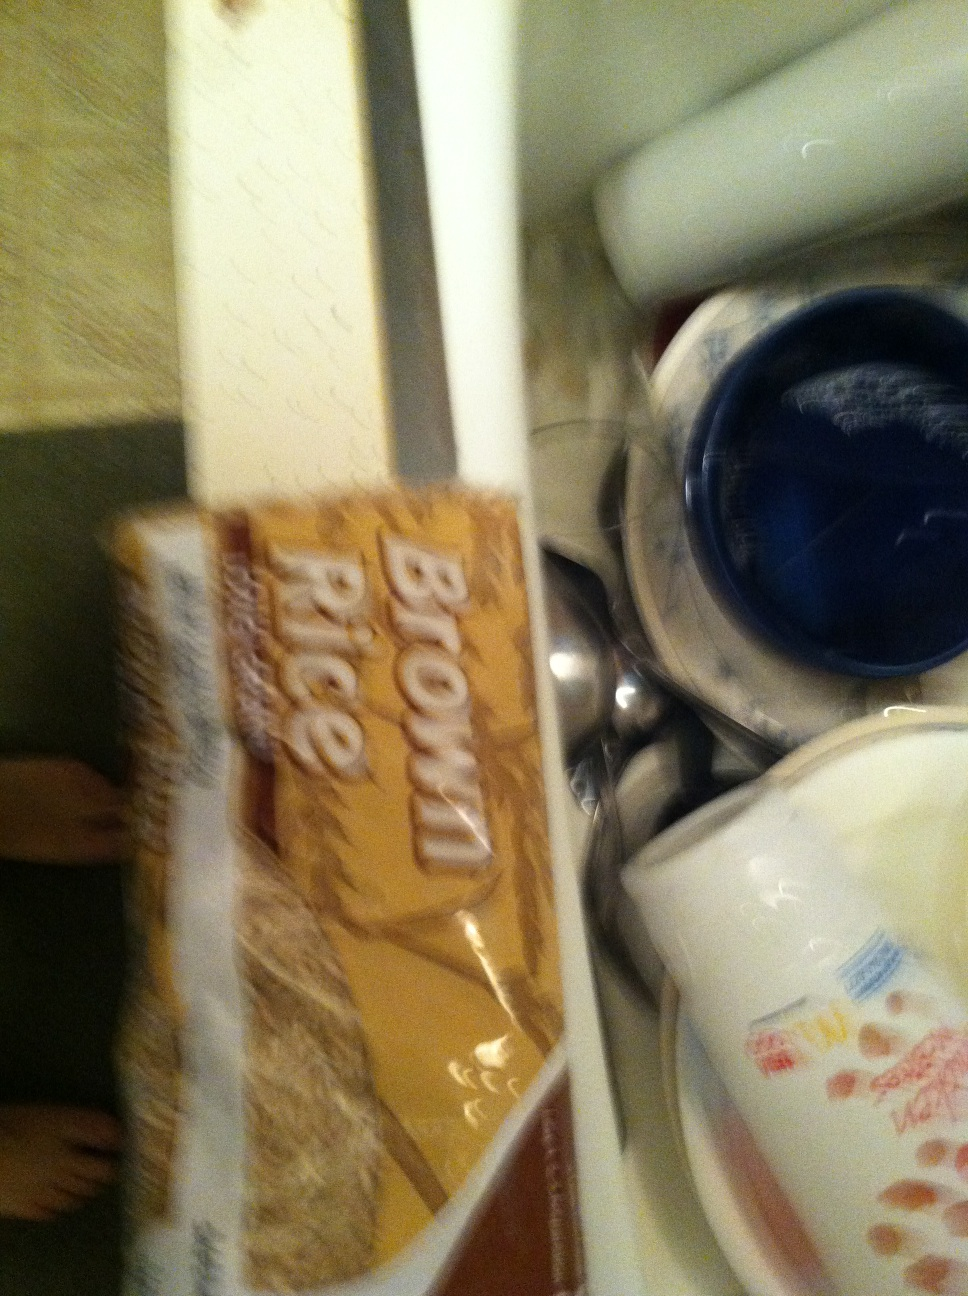

In [ ]:
test_example[0]

In [22]:
from transformers import PaliGemmaForConditionalGeneration
import gc

df = pd.read_json("./data/valid.json")
df = df[['image', 'question']]

def eval_model(EVAL_MODEL_ID):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PaliGemmaForConditionalGeneration.from_pretrained(EVAL_MODEL_ID).to(device)
    model.eval()
    TEST_BATCH_SIZE = 16

    class TestDataset(Dataset):
        def __init__(self, dataframe):
            self.dataframe = dataframe

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            row = self.dataframe.iloc[idx]
            image_path = VALIDATION_PATH + '/' + row['image']
            try:
                image = Image.open(image_path).convert("RGB")
            except OSError:
                cvimg = cv2.imread(image_path)
                image = Image.fromarray(cvimg)
            question = PROMPT + row['question']

            return image, question

    def test_collate_fn(batch):
        images, questions = zip(*batch)
        inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True, tokenize_newline_separately=False)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        return inputs

    data_loader = DataLoader(TestDataset(df), batch_size=TEST_BATCH_SIZE, collate_fn=test_collate_fn)
    torch.cuda.empty_cache()
    model_answers = []
    with torch.no_grad():
        for inputs in tqdm(data_loader, desc="Processing batches"):
            generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
            model_answers.extend([process_pred(ans.split("\n")[1]) for ans in generated_text])
            torch.cuda.empty_cache()
    submission = np.array(model_answers)
    # save to drive
    DATA_PATH = '/content/drive/MyDrive/matsuo-ken-2024-DL/VQA/'
    # add timestamp to name
    import time
    time_stamp = time.strftime("%Y%m%d-%H%M%S")
    # torch.save(model.state_dict(), DATA_PATH + 'model_' + time_stamp + '_.pth')
    np.save(DATA_PATH + 'submission_' + EVAL_MODEL_ID + '_' + time_stamp + '_.npy', submission)

    del model
    torch.cuda.empty_cache()
    gc.collect()

EVAL_MODEL_IDS = [
    "howarudo/paligemma-vqa-ft-3e5-epoch_0",
    "howarudo/paligemma-vqa-ft-3e5-epoch_1",
    "howarudo/paligemma-vqa-ft-3e5-epoch_2",
    "howarudo/paligemma-vqa-ft-3e5-epoch_3",
    "howarudo/paligemma-vqa-ft-3e5-epoch_4",
    "howarudo/paligemma-vqa-ft-3e5-epoch_5",
    "howarudo/paligemma-vqa-ft-3e5-epoch_6",
    "howarudo/paligemma-vqa-ft-3e5-epoch_7",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_0",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_1",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_2",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_3",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_4",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_5",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_6",
    "howarudo/paligemma-vqa-ft-colab-3e4-epoch_7",
]
for EVAL_MODEL_ID in EVAL_MODEL_IDS:
    eval_model(EVAL_MODEL_ID)


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [25:36<00:00,  4.94s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [25:29<00:00,  4.92s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [25:31<00:00,  4.92s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [27:39<00:00,  5.34s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [26:16<00:00,  5.07s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [25:33<00:00,  4.93s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [27:50<00:00,  5.37s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [27:51<00:00,  5.38s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 311/311 [25:05<00:00,  4.84s/it]


adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Processing batches:  68%|██████▊   | 213/311 [46:52<21:33, 13.20s/it]


KeyboardInterrupt: 

In [ ]:
submission = np.array(model_answers)
np.save("submission.npy", submission)


In [ ]:
from google.colab import runtime
runtime.unassign()